In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error, r2_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone

# helpfunctions

In [2]:
class CustomBoost(object):
    def __init__(self, base_estimator=None, n_estimators=2000, rit_alpha=1 - 1e-10, max_depth=5, nu=1):
        self.n_estimators = n_estimators
        self.rit_alpha = rit_alpha
        self.max_depth = max_depth
        self.nu = nu
        self.base_estimator = MyDecisionTreeRegressor(random_state=0,
                                                max_depth=max_depth,
                                                max_leaf_nodes=2**max_depth,
                                                rit_alpha=rit_alpha)
        if base_estimator:
            self.base_estimator = base_estimator

        self.estimators_ = [clone(self.base_estimator) for _ in range(self.n_estimators)]

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'base_estimator': self.base_estimator}
    
    def fit(self, X, y):
        f = np.zeros_like(y)
        for clf in self.estimators_:
            clf.fit(X, y-f)
            f=f+clf.predict(X) * self.nu
    def predict(self, X):
        b = [self.nu * clf.predict(X) for clf in self.estimators_]
        return np.sum(b, axis=0)

In [3]:
def separate_cb_reg(cb):
    trees = cb.estimators_
    trees_0 = [tree for tree in trees if (0 in tree.tree_.feature) and (1 not in tree.tree_.feature)]
    trees_1 = [tree for tree in trees if (1 in tree.tree_.feature) and (0 not in tree.tree_.feature)]

    model_0 = CustomBoost(n_estimators=len(trees_0), rit_alpha=cb.rit_alpha, max_depth=cb.max_depth, nu=cb.nu)
    model_0.estimators_ = trees_0
    model_1 = CustomBoost(n_estimators=len(trees_1), rit_alpha=cb.rit_alpha, max_depth=cb.max_depth, nu=cb.nu)
    model_1.estimators_ = trees_1
    return model_0, model_1

In [4]:
def hypothesis_check(rf, X_test, y_test):
    rf_0, rf_1 = separate_cb_reg(rf)

    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] =18
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.rcParams['font.size'] = 50

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 2)

    subs = []
    for sub in gs:
        subs.append(fig.add_subplot(sub))
    subs = np.array(subs).reshape(2, 2)

    x0 = X_test.transpose(1,0)[0]
    x1 = X_test.transpose(1,0)[1]
    y0_rf = rf_0.predict(X_test)
    y0_pr = x0
    y1_rf = rf_1.predict(X_test)
    y1_pr = x1

    subplotNames = ['Feature 0', 'Feature 1', 'Features', 'Features']

    for i, ax in enumerate(subs.flat):
        ax.annotate(
            text=subplotNames[i], 
            xy=(0.5, 1.05),
            xycoords='axes fraction',
            ha='center',
            fontsize=24
        )
        
        if i == 0:
            ax.set_xlabel('X0')
            ax.scatter(x0, y0_rf, 0.3, 'b', label='predicted')
            ax.scatter(x0, y0_pr, 0.3, 'r', label='hypothesis, y = x')
        if i == 1:
            ax.set_xlabel('X1')
            ax.scatter(x1, y1_rf, 0.3, 'r', label='predicted')
            ax.scatter(x1, y1_pr, 0.3, 'b', label='hypothesis, y = x')
        if i == 2:
            ax.set_xlabel('X1 + X2')
            ax.scatter(x0 + x1, y0_rf + y1_rf, 0.3, 'r', label='hypothesis, y = y1 + y2')
            ax.scatter(x0 + x1, x0 + x1, 0.3, 'b', label='y = x')
        if i == 3:
            ax.set_xlabel('X1 + X2')
            ax.scatter(x0 + x1, rf.predict(X_test), 0.3, 'r', label='predicted')
            ax.scatter(x0 + x1, x0 + x1, 0.3, 'b', label='y = x')
        
        # Настройка осей
        ax.set_ylabel('y')
        ax.legend()
    print("score = {}".format(r2_score(rf.predict(X_test), y_test)))
    print("Trees with feature 0: {}, trees with feature 1: {}, total trees: {}".format(len(rf_0.estimators_), len(rf_1.estimators_), len(rf.estimators_)))
    plt.tight_layout()
    plt.show()

# Выборки

In [5]:
def data_regression_2D_1():
  n = 2
  N = 4000

  X1 = np.random.random(N) - 0.5
  X2 = np.random.random(N) - 0.5

  y = X1 + X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [6]:
def data_regression_2D_2():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10
  X2 = np.random.randn(N) * 10

  y = X1 + X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [7]:
def data_regression_2D_3():
  n = 2
  N = 4000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [8]:
def data_regression_2D_4():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10 + 5
  X2 = np.random.randn(N) * 10 -10

  y = X1 + X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

# Проверка гипотез

## Boosting

#1 Regression, $Y = X_1 + X_2$

In [9]:
cb_1 = CustomBoost()
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cb_1.fit(X_train, y_train)

score = 0.9582639182699355
Trees with feature 0: 745, trees with feature 1: 729, total trees: 2000


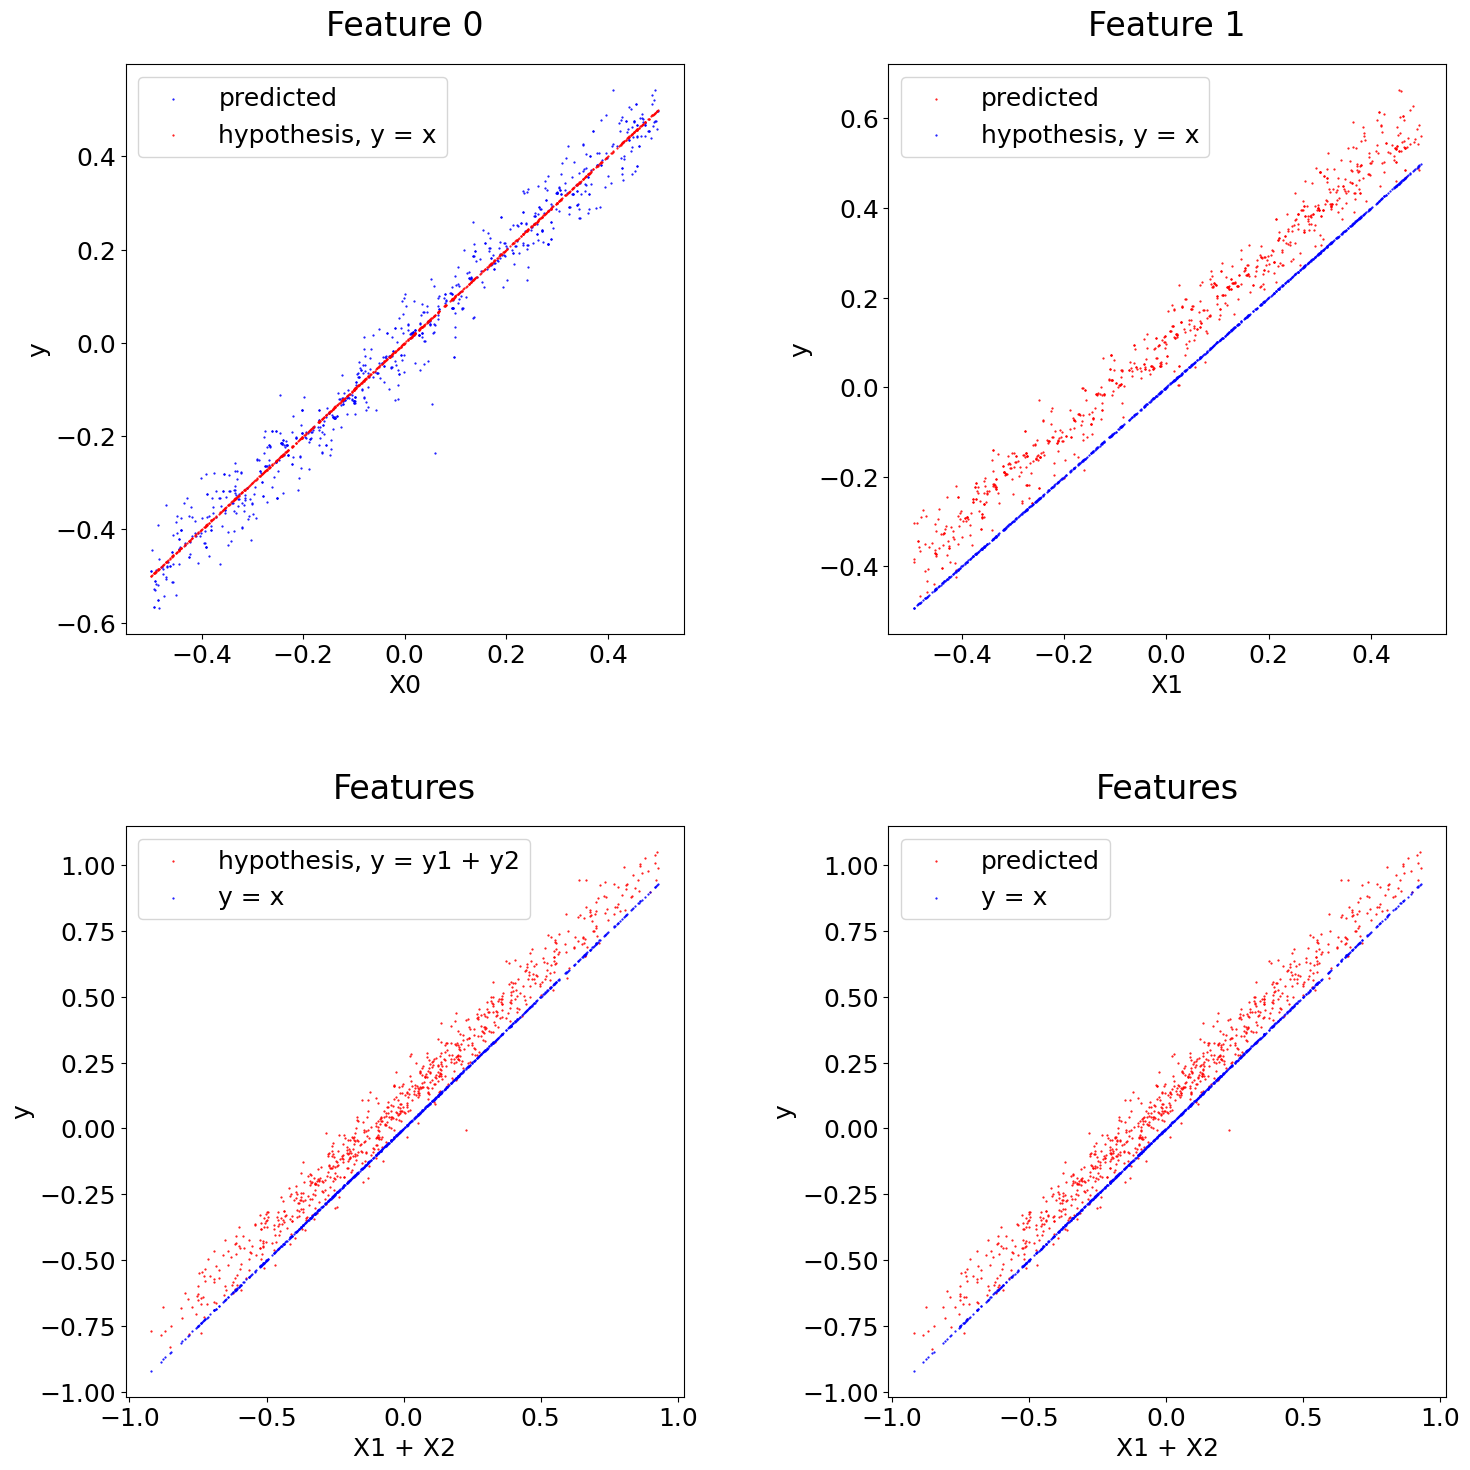

In [10]:
# Normalized uniform distribution
hypothesis_check(cb_1, X_test, y_test)

In [11]:
cb_2 = CustomBoost()
X, y = data_regression_2D_2()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cb_2.fit(X_train, y_train)

score = 0.9883008706686335
Trees with feature 0: 887, trees with feature 1: 858, total trees: 2000


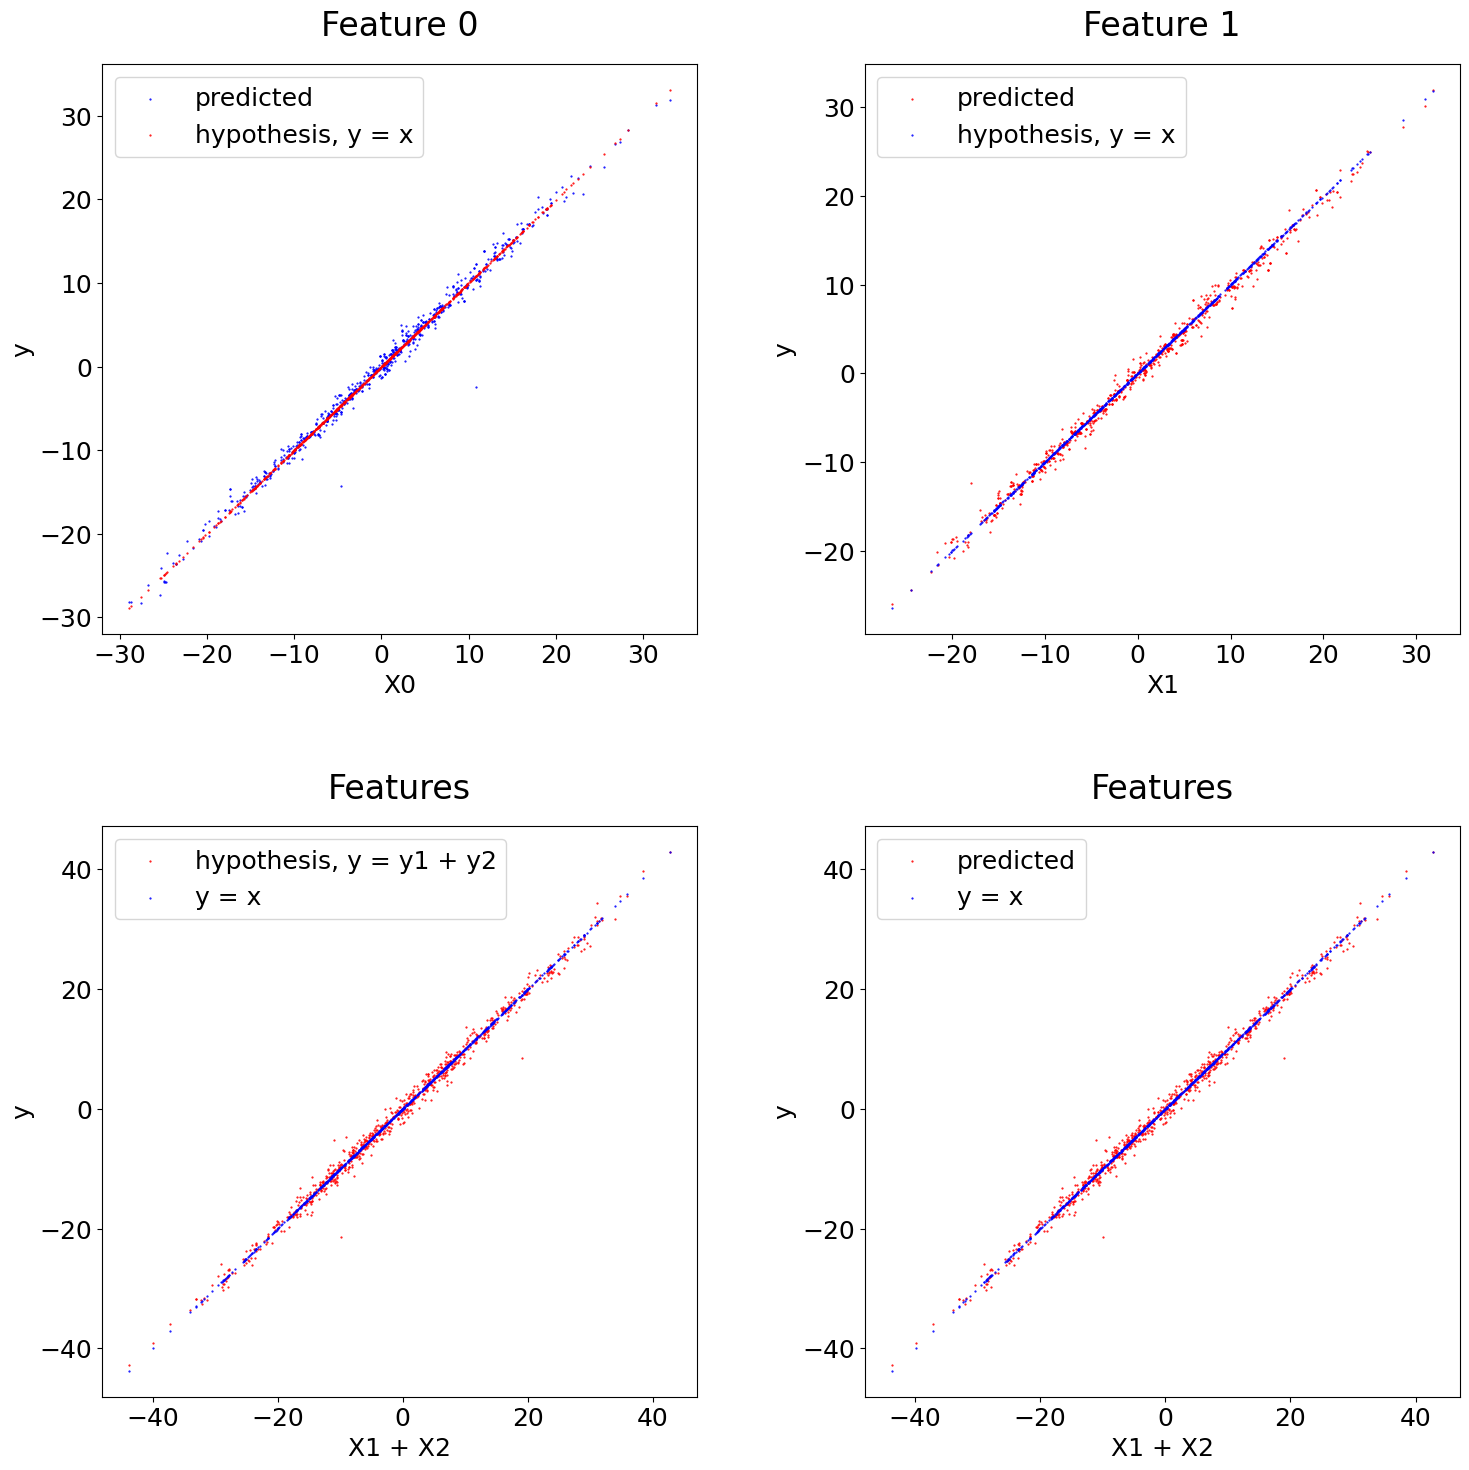

In [12]:
# Gauss distribution
hypothesis_check(cb_2, X_test, y_test)

In [13]:
cb_3 = CustomBoost()
X, y = data_regression_2D_3()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cb_3.fit(X_train, y_train)

score = 0.9603861770498856
Trees with feature 0: 749, trees with feature 1: 744, total trees: 2000


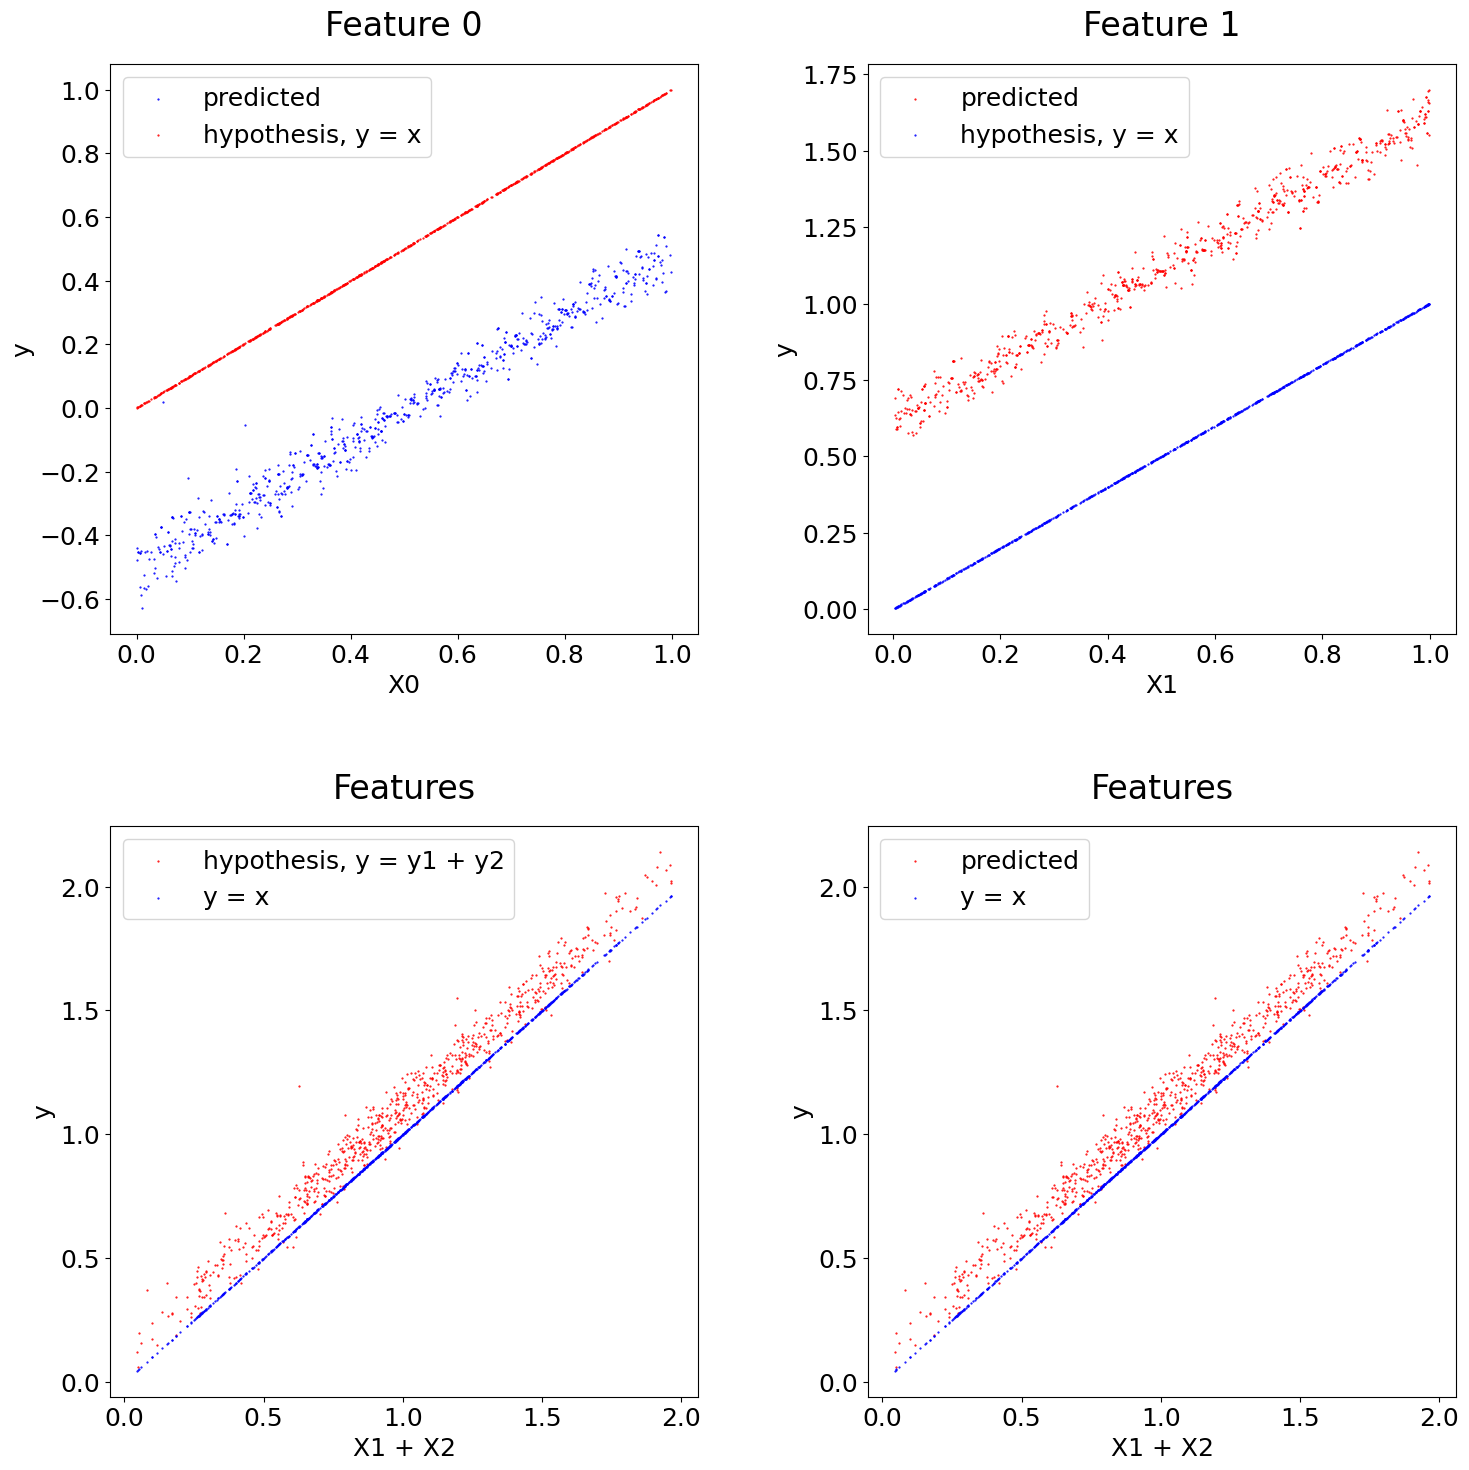

In [14]:
# Non normalized uniform distribution
hypothesis_check(cb_3, X_test, y_test)

In [15]:
cb_4 = CustomBoost()
X, y = data_regression_2D_4()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cb_4.fit(X_train, y_train)

score = 0.9827477683779742
Trees with feature 0: 869, trees with feature 1: 872, total trees: 2000


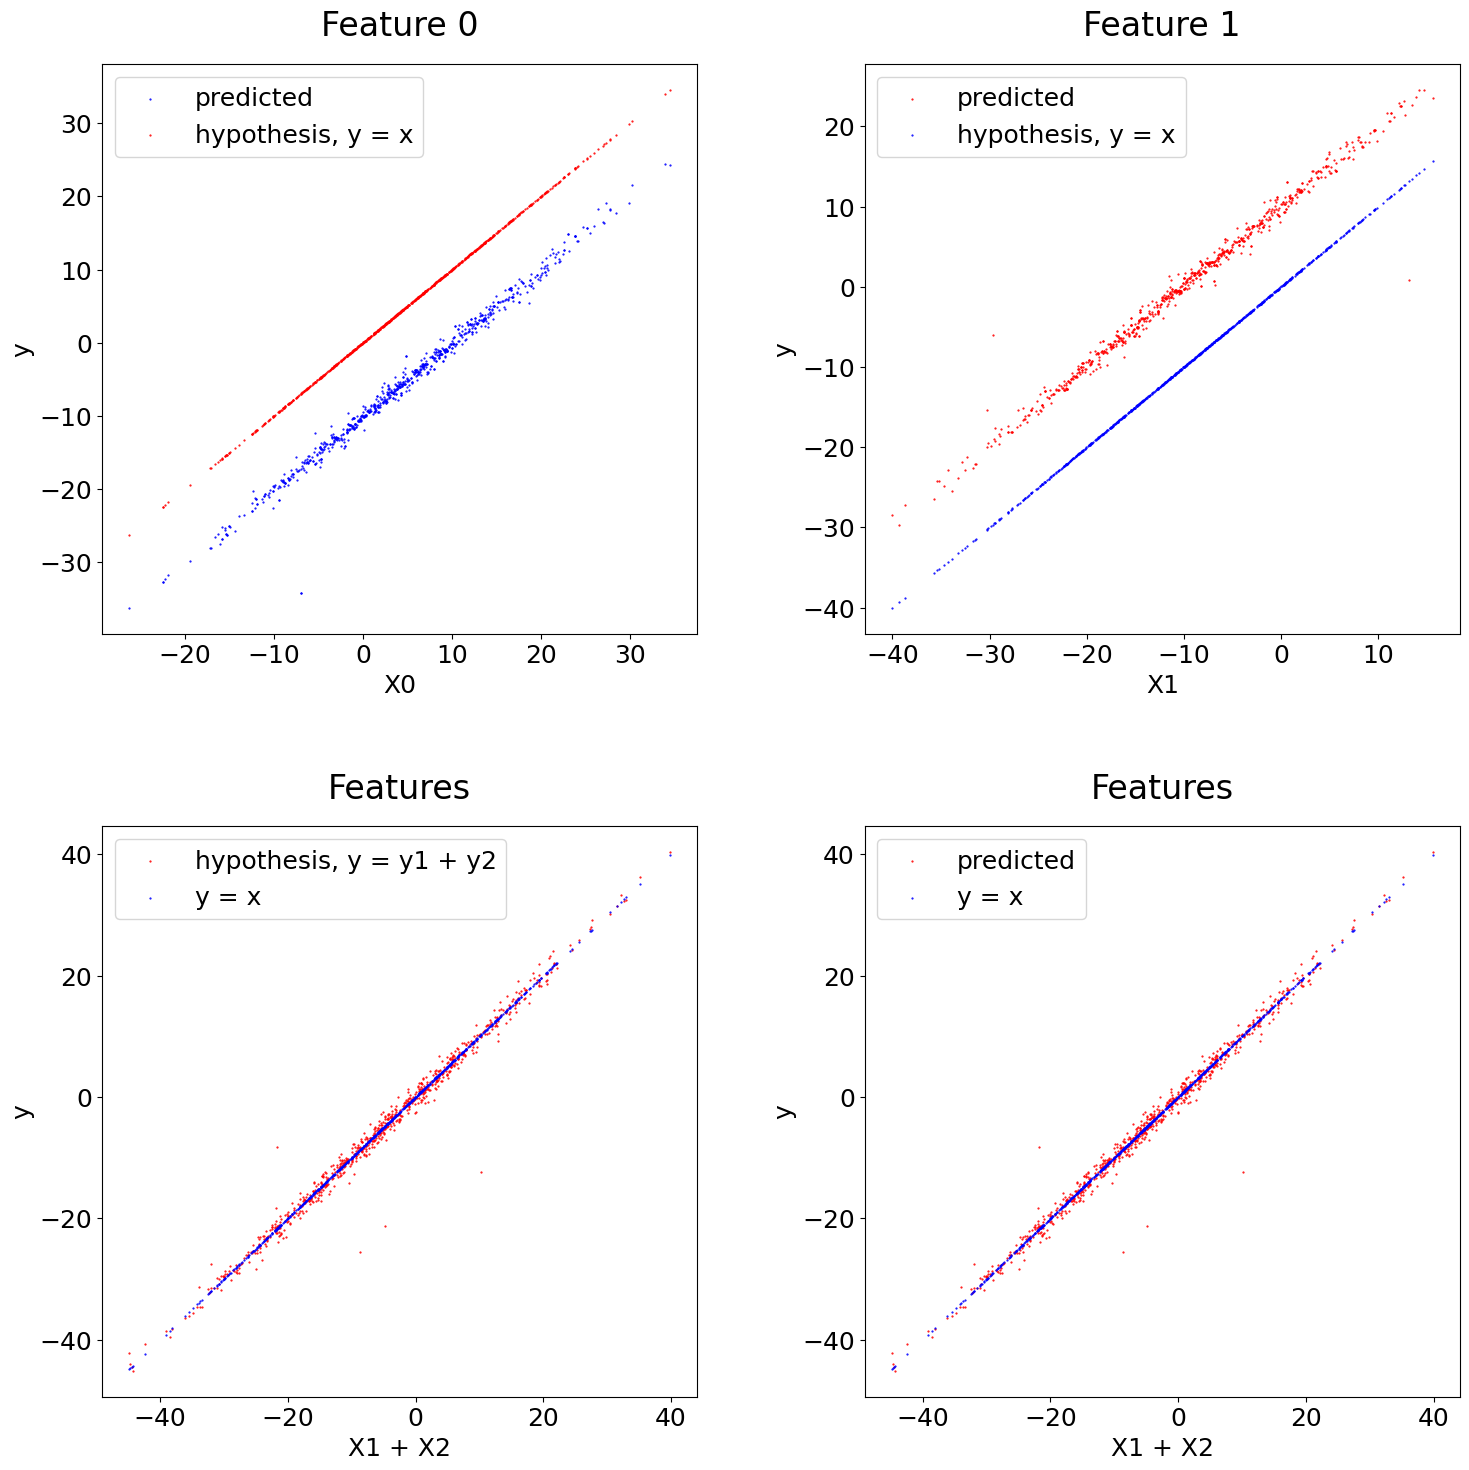

In [16]:
# Non normalized Gauss distribution
hypothesis_check(cb_4, X_test, y_test)